### Load required libraries

In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from keras import regularizers, optimizers
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import MaxPooling2D


Using TensorFlow backend.


## Private Methods Sections

###Define Cutout

Visit readme file for more details

In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

### Define LR  Finder 

In [0]:
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
            if steps_per_epoch is None:
                try:
                    steps_per_epoch = len(generator)
                except (ValueError, NotImplementedError) as e:
                    raise e('`steps_per_epoch=None` is only valid for a'
                            ' generator based on the '
                            '`keras.utils.Sequence`'
                            ' class. Please specify `steps_per_epoch` '
                            'or use the `keras.utils.Sequence` class.')
            self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(steps_per_epoch))

            # Save weights into a file
            self.model.save_weights('tmp.h5')

            # Remember the original learning rate
            original_lr = K.get_value(self.model.optimizer.lr)

            # Set the initial learning rate
            K.set_value(self.model.optimizer.lr, start_lr)

            callback = LambdaCallback(on_batch_end=lambda batch,
                                      logs: self.on_batch_end(batch, logs))

            self.model.fit_generator(generator=generator,
                                     epochs=epochs,
                                     steps_per_epoch=steps_per_epoch,
                                     callbacks=[callback],
                                     **kw_fit)

            # Restore the weights to the state before model fitting
            self.model.load_weights('tmp.h5')

            # Restore the original learning rate
            K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        print(derivatives)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

### Plot Model history

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Define accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Random crop defination

In [0]:
def random_crop(x, random_crop_size = (32,32), sync_seed=None):
    np.random.seed(sync_seed)
    w, h = x.shape[1], x.shape[2]
    rangew = (w - random_crop_size[0]) // 2
    rangeh = (h - random_crop_size[1]) // 2
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    return x[:, offsetw:offsetw+random_crop_size[0], offseth:offseth+random_crop_size[1]]

### Define One Cycle LR

In [0]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras import backend as K
from keras.callbacks import *

class OneCycleLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            current_LR = self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
            # print('Current LR is' ,current_LR)
            return current_LR
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())

## Implementations

###Parameters

In [0]:

# Training parameters
batch_size = 512  
epochs = 150
data_augmentation = True
classes = 10
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True




### Test and Train data split

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

#train_mean = np.mean(x_train, axis=(0,1,2))
train_mean = (0.4914, 0.4822, 0.4465)
#train_std = np.std(x_train, axis=(0,1,2))
train_std =  (0.2023, 0.1994, 0.2010)

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
#pad4 = lambda x: np.pad(x, [(0, 0), (0, 0), (0, 0), (0, 0)], mode='reflect')

x_train = normalize(x_train)
x_test = normalize(x_test)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, classes)
y_test = keras.utils.to_categorical(y_test, classes)

### Davidnet implementation using keras 

In [10]:
def Add_BasicLayer(input, num_filter = 12, dropout_rate = 0, add_pooling = False):
    Conv2D_1_1 = Conv2D(int(num_filter), (3,3), use_bias=False, padding='same')(input)
    BatchNorm = BatchNormalization()(Conv2D_1_1)
    output = Activation('relu')(BatchNorm)
    if add_pooling:
      output = MaxPooling2D(pool_size=(2, 2))(output)
    if dropout_rate>0:
      output = Dropout(dropout_rate)(output)
    return output
c=64
input = Input(shape=(32, 32, 3,))
prep = Add_BasicLayer(input, num_filter = c, dropout_rate = 0, add_pooling = False)

layer1_1 = Add_BasicLayer(prep, num_filter = c * 2, dropout_rate = 0, add_pooling = True)
layer1_2 = Add_BasicLayer(layer1_1, num_filter = c * 2, dropout_rate = 0, add_pooling = False)
layer1_3 = Add_BasicLayer(layer1_2, num_filter = c * 2, dropout_rate = 0, add_pooling = False)

#merge1 = concatenate([layer1_1, layer1_3], name='merge1')
#Conv2D_1 = Conv2D(32, (1,1), use_bias=False, padding='same')(merge1)
merge1 = keras.layers.add([layer1_1, layer1_3])


layer2 = Add_BasicLayer(merge1, num_filter = c * 4, dropout_rate = 0, add_pooling = True)

layer3_1 = Add_BasicLayer(layer2, num_filter = c * 8, dropout_rate = 0, add_pooling = False)
layer3_2 = Add_BasicLayer(layer3_1, num_filter = c * 8, dropout_rate = 0, add_pooling = False)
layer3_3 = Add_BasicLayer(layer3_2, num_filter = c * 8, dropout_rate = 0, add_pooling = False)

#merge2= concatenate([layer3_1, layer3_3], name='merge2')
merge2 = keras.layers.add([layer3_1, layer3_3])

output = AveragePooling2D(pool_size = (4,4))(merge2)
output = Flatten()(output)
output = Dense(10)(output)

# output = Conv2D(10, kernel_size=(1,1))(merge2)
# output = AveragePooling2D(pool_size = (4,4))(output)
# output = Flatten()(output)
output = Activation('softmax')(output)

model = Model(inputs=[input], outputs=[output])

#sgd = tf.keras.optimizers.SGD(nesterov=True)

sgd = optimizers.SGD(nesterov=True)

#loss = custom_loss()

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

W0813 02:44:23.966725 140398385862528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 02:44:23.985305 140398385862528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 02:44:23.989744 140398385862528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 02:44:24.018950 140398385862528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0813 02:44:24.019970 1403983858

### Model Summary

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Finding best LR

In [12]:
from keras.callbacks import Callback, LambdaCallback
import math

model.compile(loss='categorical_crossentropy', optimizer='ADAM', metrics=['accuracy'])
lr_finder = LRFinder(model)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1(but I'll try higher values like 3,4)
lr_finder.find(x_train, y_train, start_lr=0.0001, end_lr=50, batch_size=512, epochs=5)

W0813 02:44:26.233270 140398385862528 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
50000/50000 [==============================] - 62s 1ms/step - loss: 1.2490 - acc: 0.5584
Epoch 2/5
50000/50000 [==============================] - 52s 1ms/step - loss: 1.1032 - acc: 0.6413
Epoch 3/5
50000/50000 [==============================] - 52s 1ms/step - loss: 0.8813 - acc: 0.6971
Epoch 4/5
12800/50000 [======>.......................] - ETA: 38s - loss: 1.4756 - acc: 0.5557

#### Plot Loss

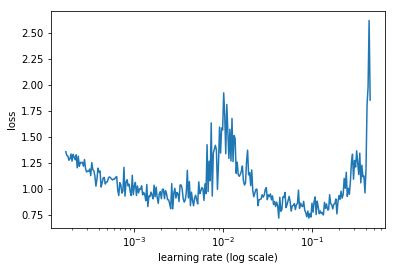

In [13]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=5) # changed n_skip_beginning from 20 to 1

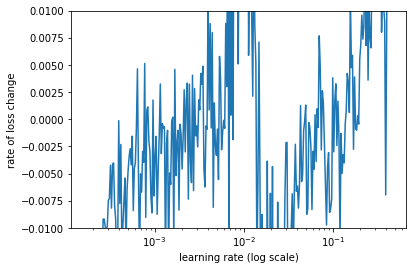

In [14]:
# Plot rate of change of the loss
# Ignore 20 batches in the beginning and 5 in the end
# Smooth the curve using simple moving average of 20 batches
# Limit the range for y axis to (-0.02, 0.01)
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.01, 0.01))

In [15]:
bestLr = lr_finder.get_best_lr(sma=20)
print(bestLr)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.08968098759651184, -0.0469321072101593, -0.03445432186126709, -0.03699927926063538, -0.02897096276283264, -0.025649797916412354, -0.027271300554275513, -0.02051992416381836, -0.019946295022964477, -0.0174816370010376, -0.014960986375808717, -0.020664727687835692, -0.017206913232803343, -0.012051379680633545, -0.014343839883804322, -0.013020187616348267, -0.009174537658691407, -0.009180635213851929, -0.009899705648422241, -0.010146087408065796, -0.009800279140472412, -0.007459920644760132, -0.007264232635498047, -0.004228365421295166, -0.008168172836303712, -0.0041477024555206295, -0.004015260934829712, -0.007906961441040038, -0.009109342098236084, -0.01267736554145813, -0.011653411388397216, -0.00012325048446655275, -0.007739925384521484, -0.002312976121902466, -0.01190827488899231, -0.009632813930511474, -0.007562482357025146, -0.005399453639984131, -0.011832207441329956, -0.006457477807998657, -0.00472765564918518, -0.00

### Set best starting LR and Compile model 

In [0]:
from keras.optimizers import SGD

sgd = SGD(lr=bestLr, momentum=0.9, decay=5e-4, nesterov=False)
K.set_value(model.optimizer.lr, 0.5 * K.get_value(sgd.lr))

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

### Define CLR parameters and model fitting

In [19]:
# from keras.utils import Sequence


# # Prepare model model saving directory.
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# #model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
    
    
#filepath = os.path.join(save_dir, model_name)
filepath = "model_accuracy_Assignment_14.best.hdf5"


# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint (
                             filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50,min_delta=0.01)



# Cyclic LR parameters
max_lr = bestLr
base_lr = bestLr//5
max_m = 0.95
base_m = 0.90
cyclical_momentum = True
augment = True
cycles = 5

iterations = round(len(x_train)/batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

clr =  OneCycleLR(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)

                         
                       

#callbacks = [checkpoint,clr_triangular] # Last working

callbacks =  [es , clr]

# get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False)

datagen = ImageDataGenerator(zoom_range=0.0, 
                             #width_shift_range=0.1, 
                             #height_shift_range=0.1,
                             horizontal_flip=0.5,
                            preprocessing_function=get_random_eraser(p=0.3,s_l=0.02, s_h=0.3, r_1=0.3, r_2=1/0.3, v_l=0, v_h=1, pixel_level=False))

    
# # Compute quantities required for featurewise normalization
# # (std, mean, and principal components if ZCA whitening is applied).
# datagen.fit(x_train)
    
   
# Fit the model on the batches generated by datagen.flow().
model_info = model.fit_generator(datagen.flow(random_crop(x_train), y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_steps = x_train.shape[0] // batch_size,
                    validation_data=(random_crop(x_test), y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)
  
 
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(x_test, y_test, model))

print("--- Total %s seconds ---" % (time.time() - start_time))

Epoch 1/150
97/97 [==============================] - 56s 574ms/step - loss: 1.6215 - acc: 0.4251 - val_loss: 3.0181 - val_acc: 0.1000
Epoch 2/150
97/97 [==============================] - 53s 551ms/step - loss: 1.1612 - acc: 0.6052 - val_loss: 2.6711 - val_acc: 0.1000
Epoch 3/150
97/97 [==============================] - 53s 551ms/step - loss: 1.1094 - acc: 0.6551 - val_loss: 2.6598 - val_acc: 0.1667
Epoch 4/150
97/97 [==============================] - 54s 552ms/step - loss: 0.8384 - acc: 0.7282 - val_loss: 1.6390 - val_acc: 0.4306
Epoch 5/150
97/97 [==============================] - 54s 553ms/step - loss: 0.7169 - acc: 0.7677 - val_loss: 1.2175 - val_acc: 0.6345
Epoch 6/150
97/97 [==============================] - 54s 553ms/step - loss: 0.6382 - acc: 0.7923 - val_loss: 1.8183 - val_acc: 0.5083
Epoch 7/150
97/97 [==============================] - 54s 552ms/step - loss: 0.5224 - acc: 0.8242 - val_loss: 1.1129 - val_acc: 0.6787
Epoch 8/150
97/97 [==============================] - 54s 552ms

KeyboardInterrupt: ignored

## Stats and Plot Graphs

### One Cycle LR

In [0]:
import matplotlib.pyplot as plt
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("One Cycle Policy")
plt.show()

### Cyclic Momentum

In [0]:
import matplotlib.pyplot as plt
plt.plot(clr.history['iterations'], clr.history['momentum'])
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("One Cycle Policy")
plt.show()

### Print Confusion matrix 

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()

### Learning Curve

In [0]:
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

In [0]:
plotKerasLearningCurve()
plt.show()

### observation :

last best conf : cycle : 5 and base_lr =bestLr//5 best:88 in 30 epochs

Round2: 

1. Latest change : cycle :  20 and base_lr =bestLr//10
2. Changed random eraser size and reduce it to .3 from .5
3. LR finder is run for 5 epochs now
4. Removed most of the hyperparameter from fit()
5. 




